In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "B"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
SCGT00_L026_I0148.3P_T0_AAAGAACAGAGTACCG,SCGT00,SCGT00_L026,SCGT00_I0148.3P_T0,3_GEX_V3,SLE,female,31-40,B,B_Naive
SCGT00_L026_I0148.3P_T0_AAAGTGACAACCAACT,SCGT00,SCGT00_L026,SCGT00_I0148.3P_T0,3_GEX_V3,SLE,female,31-40,B,B_Naive
SCGT00_L026_I0148.3P_T0_AACAACCCAGCCATTA,SCGT00,SCGT00_L026,SCGT00_I0148.3P_T0,3_GEX_V3,SLE,female,31-40,B,B_Memory_switched
SCGT00_L026_I0148.3P_T0_AACAACCCAGTGGTGA,SCGT00,SCGT00_L026,SCGT00_I0148.3P_T0,3_GEX_V3,SLE,female,31-40,B,B_Naive
SCGT00_L026_I0148.3P_T0_AACAGGGTCGTTACCC,SCGT00,SCGT00_L026,SCGT00_I0148.3P_T0,3_GEX_V3,SLE,female,31-40,B,B_Naive
...,...,...,...,...,...,...,...,...,...
Perez2022_L026_1584_T0_TTGACTTGTCGAAAGC,Perez2022,Perez2022_L026,Perez2022_1584_T0,3_GEX_V2,SLE,female,61-70,B,B_Transitional
Perez2022_L026_1584_T0_TTGGCAAGTGTCAATC,Perez2022,Perez2022_L026,Perez2022_1584_T0,3_GEX_V2,SLE,female,61-70,B,B_Transitional
Perez2022_L026_1584_T0_TTTGCGCTCATTTGGG,Perez2022,Perez2022_L026,Perez2022_1584_T0,3_GEX_V2,SLE,female,61-70,B,B_Naive


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
8,2,3,0.771165,0.031973,0.024656
15,4,3,0.800651,0.031973,0.025599
5,1,3,0.989197,0.031973,0.031627
2,0,3,0.999552,0.031973,0.031958
14,4,2,0.676691,0.440004,0.297747
13,4,1,0.472713,0.707267,0.334334
11,3,2,0.771165,0.440004,0.339316
4,1,2,0.916277,0.440004,0.403165
1,0,2,0.971643,0.440004,0.427527
6,1,4,0.472713,1.000000,0.472713


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

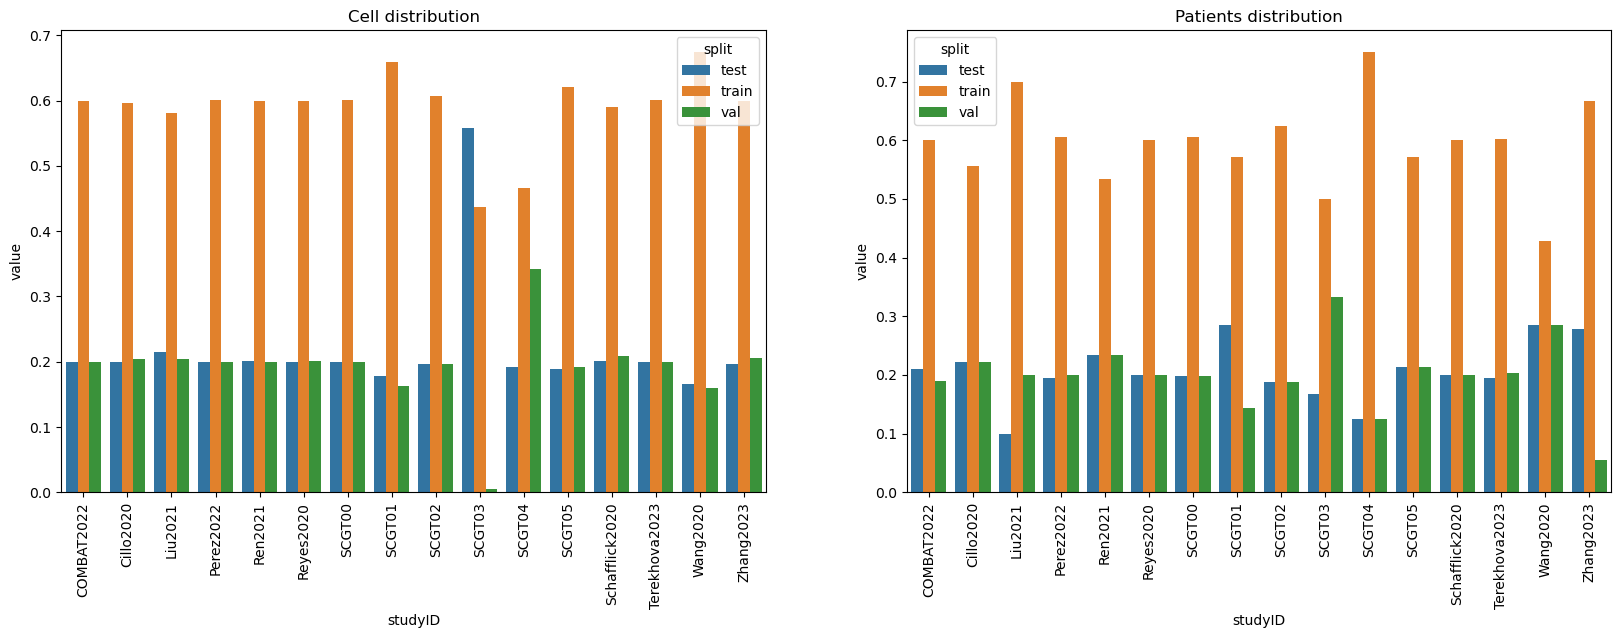

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((213238, 935), (72400, 935), (71236, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((213238,), (72400,), (71236,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-19 13:11:40,044] A new study created in memory with name: no-name-a2a20351-8073-4110-9411-32f0d19be7a5


/tmp/ipykernel_2300592/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250319_131146-eg5ywyao
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_B


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/eg5ywyao


[I 2025-03-19 13:13:58,278] Trial 0 finished with value: -0.935718 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.935718.


[I 2025-03-19 13:14:10,552] Trial 1 finished with value: -0.942393 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.942393.


[I 2025-03-19 13:14:38,068] Trial 2 finished with value: -0.932385 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.942393.


[I 2025-03-19 13:15:08,176] Trial 3 finished with value: -0.939713 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.942393.


[I 2025-03-19 13:15:36,662] Trial 4 finished with value: -0.942737 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 4 with value: -0.942737.


[I 2025-03-19 13:15:48,611] Trial 5 pruned. Trial was pruned at iteration 31.


[I 2025-03-19 13:15:58,665] Trial 6 finished with value: -0.940002 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 4 with value: -0.942737.


[I 2025-03-19 13:16:04,322] Trial 7 pruned. Trial was pruned at iteration 9.


[I 2025-03-19 13:16:08,200] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:16:12,256] Trial 9 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:16:16,411] Trial 10 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:16:39,421] Trial 11 finished with value: -0.946282 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9785259098721957, 'colsample_bynode': 0.40131565860091256, 'learning_rate': 0.08587379144532957}. Best is trial 11 with value: -0.946282.


[I 2025-03-19 13:16:56,287] Trial 12 finished with value: -0.945843 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.37777201587536535, 'colsample_bynode': 0.36301461895178766, 'learning_rate': 0.14603786032022117}. Best is trial 11 with value: -0.946282.


[I 2025-03-19 13:17:10,354] Trial 13 finished with value: -0.945364 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.3841566497358624, 'colsample_bynode': 0.304245503208456, 'learning_rate': 0.2586083232188041}. Best is trial 11 with value: -0.946282.


[I 2025-03-19 13:17:14,985] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:17:19,818] Trial 15 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:17:24,555] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:17:29,215] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:17:33,826] Trial 18 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:17:38,465] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:17:53,338] Trial 20 finished with value: -0.944192 and parameters: {'max_depth': 11, 'min_child_weight': 60, 'subsample': 0.9988286923549988, 'colsample_bynode': 0.3771398643019687, 'learning_rate': 0.08040955385444451}. Best is trial 11 with value: -0.946282.


[I 2025-03-19 13:18:07,709] Trial 21 finished with value: -0.946844 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.41147583879303956, 'colsample_bynode': 0.27682970798995915, 'learning_rate': 0.24892967230551477}. Best is trial 21 with value: -0.946844.


[I 2025-03-19 13:18:12,629] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:17,649] Trial 23 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:22,681] Trial 24 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:27,599] Trial 25 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:32,429] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:37,519] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:42,650] Trial 28 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:47,703] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:52,671] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:18:58,082] Trial 31 pruned. Trial was pruned at iteration 1.


[I 2025-03-19 13:19:03,071] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:19:08,141] Trial 33 pruned. Trial was pruned at iteration 1.


[I 2025-03-19 13:19:19,878] Trial 34 finished with value: -0.947086 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.28583560179368656, 'colsample_bynode': 0.4126063413742277, 'learning_rate': 0.42706851510395244}. Best is trial 34 with value: -0.947086.


[I 2025-03-19 13:19:24,388] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:19:29,107] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:19:33,813] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:19:38,455] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:19:43,087] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:19:47,760] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:19:59,728] Trial 41 finished with value: -0.946068 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.38034547807381147, 'colsample_bynode': 0.25529299799577804, 'learning_rate': 0.24193377687107448}. Best is trial 34 with value: -0.947086.


[I 2025-03-19 13:20:04,662] Trial 42 pruned. Trial was pruned at iteration 1.


[I 2025-03-19 13:20:09,602] Trial 43 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:20:14,651] Trial 44 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:20:19,298] Trial 45 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:20:24,402] Trial 46 pruned. Trial was pruned at iteration 1.


[I 2025-03-19 13:20:32,526] Trial 47 pruned. Trial was pruned at iteration 13.


[I 2025-03-19 13:20:37,399] Trial 48 pruned. Trial was pruned at iteration 0.


[I 2025-03-19 13:20:42,184] Trial 49 pruned. Trial was pruned at iteration 0.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_B_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:0.43260	validation_0-custom_f1_score:-0.97835


[1]	validation_0-mlogloss:0.29416	validation_0-custom_f1_score:-0.98974


[2]	validation_0-mlogloss:0.20725	validation_0-custom_f1_score:-0.99076


[3]	validation_0-mlogloss:0.14700	validation_0-custom_f1_score:-0.99194


[4]	validation_0-mlogloss:0.10779	validation_0-custom_f1_score:-0.99215


[5]	validation_0-mlogloss:0.07896	validation_0-custom_f1_score:-0.99279


[6]	validation_0-mlogloss:0.05894	validation_0-custom_f1_score:-0.99355


[7]	validation_0-mlogloss:0.04586	validation_0-custom_f1_score:-0.99371


[8]	validation_0-mlogloss:0.03576	validation_0-custom_f1_score:-0.99433


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.4126063413742277,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x74ba6384a700>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.42706851510395244, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=9, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_B_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[13:20:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


